In [1]:
%load_ext autoreload
%autoreload 2

# Develop CT-RNN animation
The purpose of this notebook is to visualize the dynamics of a CT-RNN computing the ModularArithmeticTask via a Plotly animation.

## Imports

In [2]:
import json
import os
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

import jax.numpy as jnp
from jax import random
from flax import linen as nn
from modularRNN.model import CTRNNCell
from modularRNN.task import ModularArithmeticTask
from modularRNN.training import create_train_state, ModelParameters

from sklearn.decomposition import PCA

from functools import partial

## Graphs of interest

In [3]:
hyperparameter_search = 'hyperparameter_2'
task_id = 'task_207'

params_for_json = f"../data/{hyperparameter_search}/{task_id}/params.json"
example_csv = f"../data/{hyperparameter_search}/{task_id}/metrics_history.csv"
model_params_save = f"../data/{hyperparameter_search}/{task_id}/test_params.bin"

with open(params_for_json, 'r') as f:
    json_params = json.load(f)

seed = json_params.get('seed', 0)
alpha = json_params.get('alpha', 0.1)
noise = json_params.get('noise', 0.05)
pulse_mean = json_params.get('pulse_mean', 12)
mod_set = json_params.get('mod_set', [5,])
training_trials = json_params.get('training_trials', 3200)
testing_trials = json_params.get('testing_trials', 640)
train_batch_size = json_params.get('train_batch_size', 128)
lr = json_params.get('lr', 0.001)
epochs = json_params.get('epochs', 500)
weight_decay = json_params.get('weight_decay', 0.0001)
l2_penalty = json_params.get('l2_penalty', 0.0001)
trial_length = json_params.get('trial_length', 100)

key = random.PRNGKey(seed)

In [4]:
mod_set = jnp.array(mod_set)
pulse_distribution = partial(random.poisson, lam=pulse_mean)

key, subkey = random.split(key)
modtask = ModularArithmeticTask(
    subkey, 
    training_trials, 
    testing_trials, 
    train_batch_size, 
    mod_set, 
    pulse_distribution, 
    trial_length,
)
training_dataset, testing_dataset = modtask.tf_datasets()

features = 100
alpha = jnp.float32(alpha)
noise = jnp.float32(noise)

ctrnn = nn.RNN(CTRNNCell(features=features, alpha=alpha, noise=0.00, out_shape=10,))

key, subkey = random.split(key)
state = create_train_state(ctrnn, subkey, lr, weight_decay, trial_length)

model_params = ModelParameters(state)
model_params.deserialize(model_params_save,)

100%|███████████████████████████████████████| 640/640 [00:00<00:00, 1016.16it/s]


In [5]:
inputs_list = []
labels_list = []
rates_list = []
outputs_list = []

for _inputs, _labels in tqdm(training_dataset.as_numpy_iterator()):
    key, subkey = random.split(key)
    _outputs, _rates = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)

    inputs_list.append(_inputs)
    labels_list.append(_labels)
    rates_list.append(_rates)
    outputs_list.append(_outputs)

inputs_ = jnp.concatenate(inputs_list, axis=0)
labels_ = jnp.concatenate(labels_list, axis=0)
rates_ = jnp.concatenate(rates_list, axis=0)
outputs_ = jnp.concatenate(outputs_list, axis=0)

rates_reshaped = rates_.reshape(-1, rates_.shape[-1])

pca = PCA(n_components=3)
pca.fit(rates_reshaped)

50it [00:09,  5.42it/s]2024-04-07 15:55:28.948541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



PCA(n_components=3)

In [6]:
# Create specific trial indicies and pulses
mod_value = 3
pulse_indicies = jnp.array([5, 25, 45, 65, 85, 100,])
pulse_values = jnp.array([1, 1, 1, 1, 1, 1,])
modtask.trial_length = 120
pulses, cumulative_mod = modtask.create_pulses_and_cumulative_mod(pulse_indicies, pulse_values, mod_value)
input_tensor, output_tensor = modtask.create_input_output_tensors(pulses, cumulative_mod, mod_value)

key, subkey = random.split(key)
trial_outputs, trial_rates = ctrnn.apply(model_params.params, jnp.expand_dims(input_tensor, axis=0), init_key=subkey,)

trial_rates_pc = pca.transform(trial_rates[0])
trial_rates_pc.shape

(120, 3)

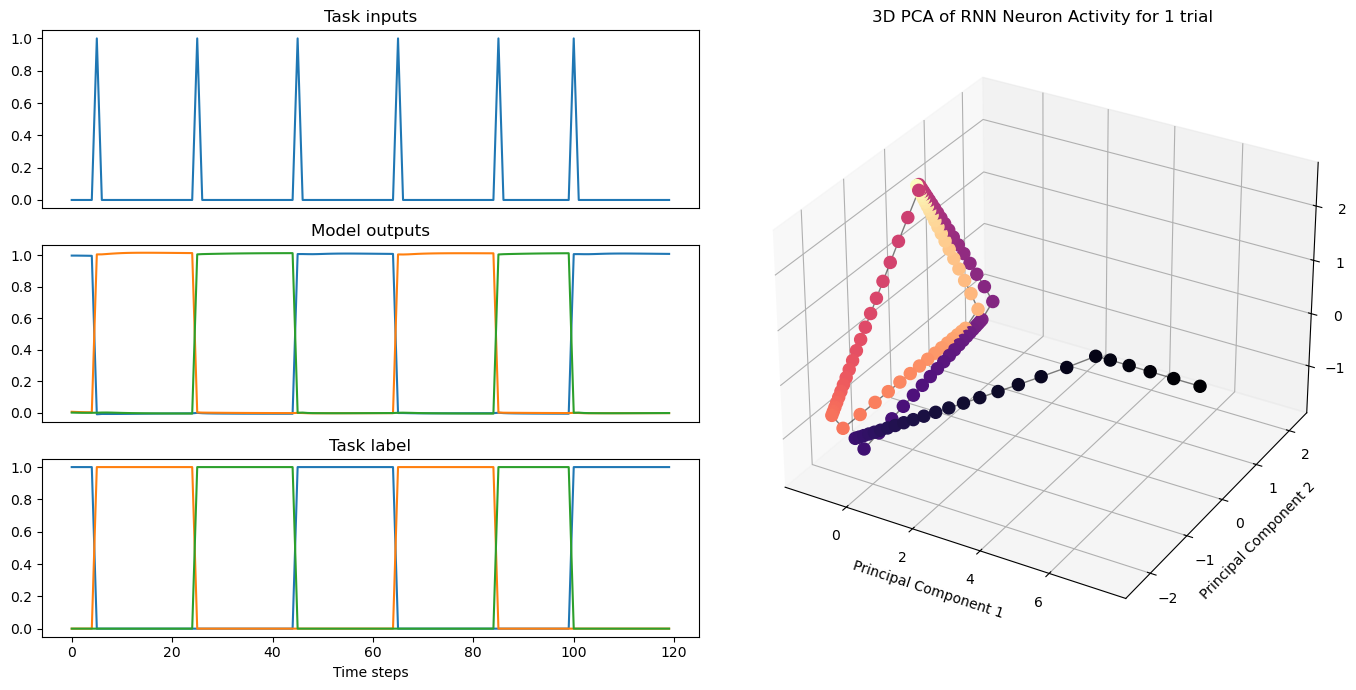

In [7]:
fig = plt.figure(figsize=(14, 7))
gs = GridSpec(3, 2)

# Panel 1: Task Inputs
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(input_tensor[:, 10:11])
ax1.set_title('Task inputs')
ax1.set_xticks([])

# Panel 2: Model Outputs
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(trial_outputs[0, :, :3])
ax2.set_title('Model outputs')
ax2.set_xticks([])

# Panel 3: Label Outputs
ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(output_tensor[:, :3])
ax3.set_title('Task label')
ax3.set_xlabel('Time steps')

# Panel 4: 3D PCA of RNN Neuron Activity
ax4 = fig.add_subplot(gs[:, 1], projection='3d')

x, y, z = trial_rates_pc[:,0], trial_rates_pc[:,1], trial_rates_pc[:,2]

ax4.plot(x, y, z, color='black', linewidth=1, alpha=0.5)
sc = ax4.scatter(x, y, z, c=jnp.arange(trial_rates_pc.shape[0]), cmap='magma', depthshade=False, s=75)

ax4.set_xlim([x.min()-0.5, x.max()+0.5])
ax4.set_ylim([y.min()-0.5, y.max()+0.5])
ax4.set_zlim([z.min()-0.5, z.max()+0.5])

ax4.set_xlabel('Principal Component 1')
ax4.set_ylabel('Principal Component 2')
ax4.set_zlabel('Principal Component 3')
ax4.set_title('3D PCA of RNN Neuron Activity for 1 trial')

plt.tight_layout()
plt.show()

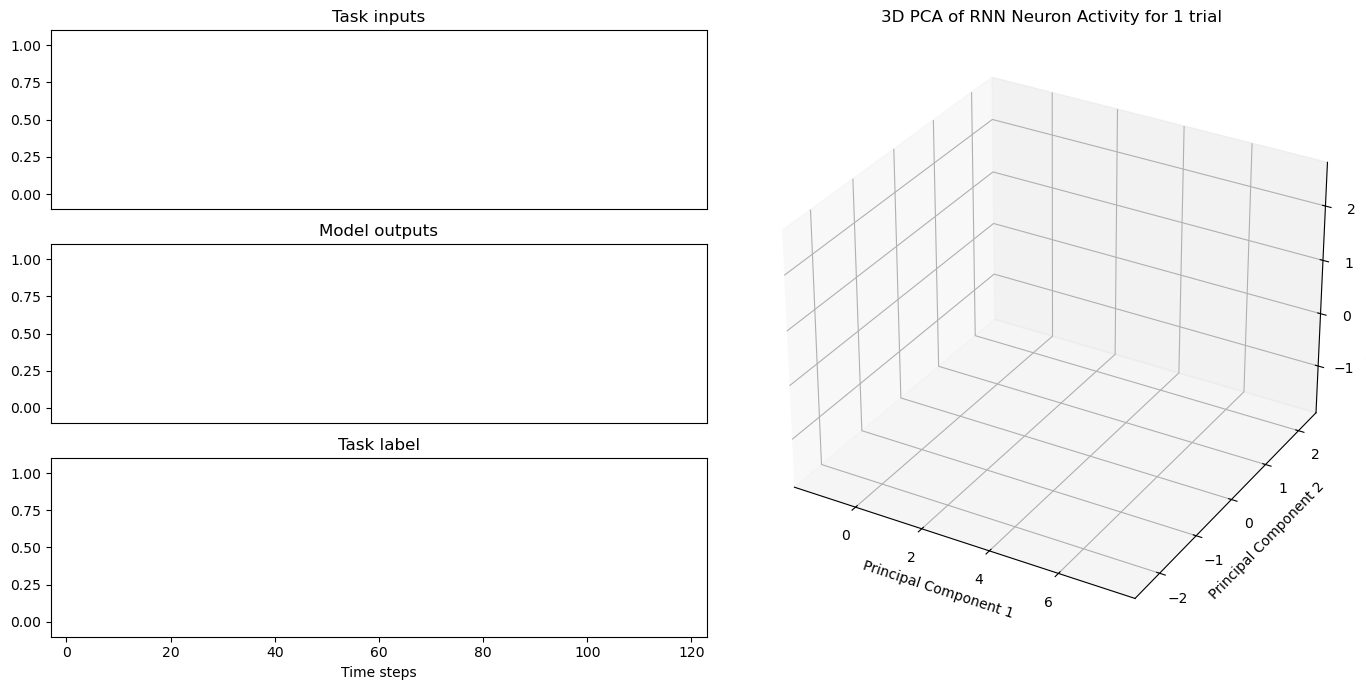

In [8]:
fig = plt.figure(figsize=(14, 7))
gs = GridSpec(3, 2)

# Panel 1: Task Inputs
ax1 = fig.add_subplot(gs[0, 0])
line1_0, = ax1.plot([], [], color='tab:blue')
line1_1, = ax1.plot([], [], color='tab:orange')
ax1.set_title('Task inputs')
ax1.set_xticks([])
ax1.set_xlim(-3, 123)
ax1.set_ylim(-0.1, 1.1)

# Panel 2: Model Outputs
ax2 = fig.add_subplot(gs[1, 0])
line2_0, = ax2.plot([], [], color='tab:red')
line2_1, = ax2.plot([], [], color='tab:purple')
line2_2, = ax2.plot([], [], color='tab:green')
ax2.set_title('Model outputs')
ax2.set_xticks([])
ax2.set_xlim(-3, 123)
ax2.set_ylim(-0.1, 1.1)

# Panel 3: Label Outputs
ax3 = fig.add_subplot(gs[2, 0])
line3_0, = ax3.plot([], [], color='tab:red')
line3_1, = ax3.plot([], [], color='tab:purple')
line3_2, = ax3.plot([], [], color='tab:green')
ax3.set_title('Task label')
ax3.set_xlabel('Time steps')
ax3.set_xlim(-3, 123)
ax3.set_ylim(-0.1, 1.1)

# Panel 4: 3D PCA of RNN Neuron Activity
norm = Normalize(vmin=0, vmax=trial_rates_pc.shape[0]-1)
cmap = plt.get_cmap('magma')
colors = cmap(norm(jnp.arange(trial_rates_pc.shape[0])))

ax4 = fig.add_subplot(gs[:, 1], projection='3d')

line4 = ax4.plot([], [], [], color='black', linewidth=1, alpha=0.5)
sc = ax4.scatter([], [], [], depthshade=False, s=75)

ax4.set_xlim([x.min()-0.5, x.max()+0.5])
ax4.set_ylim([y.min()-0.5, y.max()+0.5])
ax4.set_zlim([z.min()-0.5, z.max()+0.5])

ax4.set_xlabel('Principal Component 1')
ax4.set_ylabel('Principal Component 2')
ax4.set_zlabel('Principal Component 3')
ax4.set_title('3D PCA of RNN Neuron Activity for 1 trial')

def update(frame):
    # Update each line in all subplots
    line1_0.set_data(jnp.arange(frame), input_tensor[:frame, 10:11])
    line1_1.set_data(jnp.arange(frame), input_tensor[:frame, 11:12])
    
    line2_0.set_data(jnp.arange(frame), trial_outputs[0, :frame, :1])
    line2_1.set_data(jnp.arange(frame), trial_outputs[0, :frame, 1:2])
    line2_2.set_data(jnp.arange(frame), trial_outputs[0, :frame, 2:3])

    line3_0.set_data(jnp.arange(frame), output_tensor[:frame, :1])
    line3_1.set_data(jnp.arange(frame), output_tensor[:frame, 1:2])
    line3_2.set_data(jnp.arange(frame), output_tensor[:frame, 2:3])

    # Update the 3D line plot
    line4[0].set_data(x[:frame], y[:frame])
    line4[0].set_3d_properties(z[:frame])
    
    sc._offsets3d = (x[:frame], y[:frame], z[:frame])
    sc.set_facecolors(colors[:frame])
    
    return line1_0, line1_1, line2_0, line2_1, line2_2, line3_0, line3_1, line3_2, line4, sc, 

num_frames = 120
ani = FuncAnimation(fig, update, frames=num_frames, interval=150, blit=False)

plt.tight_layout()
plt.show()

ani.save('rnn_pca_activity.mp4', writer='ffmpeg')